## One lane simulation

In [15]:
import numpy as np
import matplotlib.pyplot as plt

class TrafficSimulation:
    
    def __init__(self, road_length = 100, density = 0.2, max_vel = 5, p_slowdown = 0.5, initial_config = False):
        self.road_length = road_length
        self.density = density
        self.max_vel = max_vel
        self.p_slowdown = p_slowdown
        if not initial_config:
            self.state = np.zeros(road_length)
            #initial empty locations (-1s)
            init_empty_loc = np.random.choice(list(range(road_length)),int((1-density)*road_length), replace=False)
            for loc in init_empty_loc:
                self.state[loc] = -1
        else:
            self.state = np.array(initial_config)
    
    def update(self):
        flows = 0
        #move cars
        new_state = np.array([-1]*self.road_length)
        for i in range(self.road_length):
            if self.state[i] >= 0:
                if i+self.state[i] >= self.road_length:
                       flows+=1
                new_state[int((i+self.state[i])%self.road_length)]=self.state[i]
        self.state = new_state
        
        #updating velocities
        for i in range(self.road_length):
            if self.state[i] >= 0:
                new_vel = self.state[i]
                #rule 1
                if self.state[i] < self.max_vel:
                    new_vel+=1

                #rule 2
                #check distance
                distance = 5
                for d in range(1,6):
                    if self.state[int((i+d)%self.road_length)] != -1:
                        distance = d-1
                        break
                if new_vel > distance:
                    new_vel = distance

                #rule 3
                if new_vel >= 1:
                    if np.random.random() < self.p_slowdown:
                        new_vel-=1
                #update_vel
                self.state[i] = new_vel
        return flows
    
    def display(self):
        print(''.join('.' if x==-1 else str(int(x)) for x in self.state))

In [16]:
sim2 = TrafficSimulation(road_length = 100, density = 0.1, max_vel = 5, p_slowdown = 0.5)
for i in range(22):
    sim2.display()
    sim2.update()

............0...0............00.................0.......0..........00................0.............0
............1...0............00.................1.......1..........00................1.............0
.............2..0............01..................2.......1.........00.................2............1
1..............01............0.1...................3......1........00...................3...........
.1.............1.2...........1..2.....................3....1.......01......................3........
..2.............2..2..........1...2......................1..1......0.1........................4.....
....2.............1..3.........2....3.....................1..1.....0..1...........................4.
..2...3............1....4........3.....4...................2..1....0...1............................
....3....3..........2.......5.......4......5.................1.1...1....2...........................
.......3....3.........3..........4......5.......4.............0.1...1.....2................

In [17]:
#function to get flow from simulation
def get_q(p = 0.1, n_sims = 20, timesteps = 200, t_0 = 100, display = False):
    sim = TrafficSimulation(density = p, max_vel = 5, p_slowdown = 0.5)
    flows = []
    for i in range(n_sims):
        flow_counter = 0
        #simulate without collecting data for the first t_0 timesteps
        for _ in range(t_0):
            sim.update()
        for t in range(timesteps):
            flow_counter+=sim.update()
        flows.append(flow_counter/timesteps)
    return sum(flows)/n_sims  

Let's say we have a one-lane road with $N$ cells and $k$ cars. For any given cell $i$ at any time $t$, $$p(i^{(t)}\geq 0) = \frac{k}{N}$$ and $$p(i^{(t)} = -1) = 1-\frac{k}{N}$$
Now, let's say $v_j^{(t)}$ is the velocity of car $j$ at time $t$ where $j = 1,2,...,k$. 

At the beginning of each simulation, all cars start with velocity $0$. This means that:

$$p(v_j^{(0)}=0) = 1$$ $$p(v_j^{(0)}>0) = 0$$  $$\forall j = 1,2, ..., k$$

We can also derive the following general recursive relation:

$$p(v_j^{(t)}=u) = [p(x_{[j+1, j+u+1]} = u*"-1") \cdot p(v_j^{(t-1)} = u-1) + p(x_{[j+1, j+u+1]} = u*"-1"+"c") \cdot p(v_j^{(t-1)} \geq u))] \cdot (1-p_{slowdown})+ [(p(x_{[j+1, j+u+2]} = (u+1)*"-1") \cdot p(v_j^{(t-1)} = u) + p(x_{[j+1 ,j+u+2]} = (u+1)*"-1"+"c") \cdot p(v_j^{(t-1)} \geq u+1)] \cdot p_{slowdow} $$ $$\forall j = 1,2, ..., k$$ for $u=1,2,3,4,5$

$$p(v_j^{(t)}=0) = p(x_{j+1}="c") + [p(v_j^{(t-1)} = 0)*p(x_{j+1}="-1")+p(v_j^{(t-1)} \geq 1)*p(x_{[j+1,j+2]} = "-1c")] \cdot p_{slowdown}$$

$$p(v_j^{(t)}>5) = 0$$

where $x_j$ is the position of the $j^{th}$ car and $p(x_{[j+1, j+u+1]} = u*"-1")$ is the probability that the next $u$ positions have no cars and $p(x_{[j+1,j+u+1]} = u*"-1"+"c")$ is the probability that the next $u$ positions have no cars and there's a car with any speed $c$ on position $u+1$.

#### Explanation

The probability of a car to have speed $u > 0$ at time $t$ is the probability that the speed of that car at the previous timestep $t-1$ was $u-1$ and that the next $u$ cells are empty so the car does not slow down after accelerating to $u$:

$$p(x_{[j+1, j+u+1]} = u*"-1") \cdot p(v_j^{(t-1)} = u-1)$$

Plus the probability that the speed of the car was at least $u$ and there is a car at distance $u$ so that on the second step of the update rule, the car slows down to speed $u$:

$$p(x_{[j+1, j+u+1]} = u*"-1"+"c") \cdot p(v_j^{(t-1)} \geq u))$$

The sum of these last two probabilities is multiplied times the probability of the car NOT slowing down to $u-1$ on step 3:

$$[p(x_{[j+1, j+u+1]} = u*"-1") \cdot p(v_j^{(t-1)} = u-1) + p(x_{[j+1, j+u+1]} = u*"-1"+"c") \cdot p(v_j^{(t-1)} \geq u))] \cdot (1-p_{slowdown})$$

Now, analogously, the probability of the car going to speed $u+1$ on the first two steps is:

$$(p(x_{[j+1, j+u+2]} = (u+1)*"-1") \cdot p(v_j^{(t-1)} = u) + p(x_{[j+1 ,j+u+2]} = (u+1)*"-1"+"c") \cdot p(v_j^{(t-1)} \geq u+1)$$

And this last expression is multiplied times the probability that on step 3 the car DOES slow down to $u$:

$$[(p(x_{[j+1, j+u+2]} = (u+1)*"-1") \cdot p(v_j^{(t-1)} = u) + p(x_{[j+1 ,j+u+2]} = (u+1)*"-1"+"c") \cdot p(v_j^{(t-1)} \geq u+1)] \cdot p_{slowdow}$$

Putting everything together gives us $p(v_j^{(t)}=u)$

Finally, the probability that a car has speed $0$ is the probability that the next cell is occupied by a cell (in that case no matter what, the car will slow down to $0$):

$$p(x_{j+1}="c")$$

Plus the probability that there's a car at distance $1$ from the car (in which case now matter what was the initial speed, after steps 1 and 2, the car will be at velocity $1$) and then this multiplied times the probability that the car DOES slow down to $0$:

$$[p(x_{[j+1,j+2]} = "-1c")] \cdot p_{slowdown}$$

Finally, the probability that a car has speed greater than $5$ is $0$.

In [99]:
#getting probability of a given sequence based on density
def pdf_next_seq(seq,k,N):
    prod = 1
    ones_left = k-1
    for i in range(len(seq)):
        if seq[i] == "1":
            prod*=ones_left/(N-1-i)
            ones_left-=1
        elif seq[i] == "0":
            prod*=(1-ones_left/(N-1-i))
    return prod

#class to compute MFA based on equations above
class MFA_traffic:
    def __init__(self,k=20,N=100,q=0.5):
        self.k = k
        self.N = N
        self.q = q
        self.saved = {} #dictionary to save already computed probabilities to make it more time-efficient
        
    def pdf_velocity(self,v,t):
        if "p_{}_{}".format(v,t) in self.saved:
            return self.saved["p_{}_{}".format(v,t)]
        else:
            k = self.k
            N = self.N
            q = self.q
            if t == 0:
                if v == 0:
                    return 1
                else:
                    return 0
            else:
                #checking whether probabilities for t-1 are available
                Ppt = [] #probabilities previous timestep
                
                for i in range(6):
                    pv_equal_i = self.saved["p_{}_{}".format(v,t)] if "p_{}_{}".format(v,t) in self.saved else self.pdf_velocity(i,t-1)
                    Ppt.append(pv_equal_i)
                
                if v>0:
                    term1 = np.sum(Ppt[max(0,v-1):v])*pdf_next_seq("0"*v,k,N)
                    term2 = np.sum(Ppt[v:])*pdf_next_seq("0"*v+"1",k,N)
                    term3 = np.sum(Ppt[v])*pdf_next_seq("0"*(v+1),k,N)
                    term4 = np.sum(Ppt[min(v+1,5):])*pdf_next_seq("0"*(v+1)+"1",k,N)
                    result = (term1+term2)*(1-q)+(term3+term4)*q
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
                else:
                    result = (k-1)/(N-1) + (Ppt[0]*pdf_next_seq("0",k,N) + np.sum(Ppt[1:])*pdf_next_seq("01",k,N))*q
                    self.saved["p_{}_{}".format(v,t)] = result
                    return result
                
#                 if v == 0:
#                     result = (k-1)/(N-1) + pdf_next_seq("01",k,N)*q
#                     self.saved["p_{}_{}".format(v,t)] = result
#                     return result
#                 elif v == 1:
#                     #no slowdown
#                     term1 = pv_0*pdf_next_seq("0",k,N)
#                     term2 = (pv_1+pv_2+pv_3+pv_4+pv_5)*pdf_next_seq("01",k,N)
                    
#                     #slowdown
#                     term3 = pv_1*pdf_next_seq("00",k,N)
#                     term4 = (pv_2+pv_3+pv_4+pv_5)*pdf_next_seq("001",k,N)
                    
#                     result = (term1+term2)*(1-q)+(term3+term4)*q
#                     self.saved["p_{}_{}".format(v,t)] = result
#                     return result
#                 elif v == 2:
#                     #no slowdown
#                     term1 = pv_1*pdf_next_seq("00",k,N)
#                     term2 = (pv_2+pv_3+pv_4+pv_5)*pdf_next_seq("001",k,N)
                    
#                     #slowdown
#                     term3 = pv_2*pdf_next_seq("000",k,N)
#                     term4 = (pv_3+pv_4+pv_5)*pdf_next_seq("0001",k,N)
                    
#                     result = (term1+term2)*(1-q)+(term3+term4)*q
#                     self.saved["p_{}_{}".format(v,t)] = result
#                     return result
#                 elif v == 3:
#                     #no slowdown
#                     term1 = pv_2*pdf_next_seq("000",k,N)
#                     term2 = (pv_3+pv_4+pv_5)*pdf_next_seq("0001",k,N)
                    
#                     #slowdown
#                     term3 = pv_3*pdf_next_seq("0000",k,N)
#                     term4 = (pv_4+pv_5)*pdf_next_seq("00001",k,N)
                    
#                     result = (term1+term2)*(1-q)+(term3+term4)*q
#                     self.saved["p_{}_{}".format(v,t)] = result
#                     return result
#                 elif v == 4:
#                     #no slowdown
#                     term1 = pv_3*pdf_next_seq("0000",k,N)
#                     term2 = (pv_4+pv_5)*pdf_next_seq("00001",k,N)
                    
#                     #slowdown
#                     term3 = (pv_4+pv_5)*pdf_next_seq("00000",k,N)
#                     result = (term1+term2)*(1-q)+term3*q
                    
#                     self.saved["p_{}_{}".format(v,t)] = result
#                     return result
#                 elif v == 5:
#                     result = ((pv_4+pv_5)*pdf_next_seq("00000",k,N))*(1-q)
#                     self.saved["p_{}_{}".format(v,t)] = result
#                     return result
    
    def flow(self,t=200):
        k = self.k
        N = self.N
        avg_timestep_size = np.sum([self.pdf_velocity(v,t)*v for v in range(6)])
        time_full_lap = N/avg_timestep_size
        return k/time_full_lap

In [108]:
mfa = MFA_traffic(10,100,0)

In [95]:
mfa.pdf_velocity(0,1)

result is
0.5454545454545454


0.5454545454545454

In [109]:
np.sum([mfa.pdf_velocity(v,1000) for v in range(6)])

0.6305282188668453

In [46]:
#running simulation 
N=60
flow = np.zeros(N)
t = np.linspace(0,0.8,N)
for i in range(N):
    flow[i] = get_q(p=t[i])

KeyboardInterrupt: 

In [20]:
#running simulation for a larger number of timesteps
flow2 = np.zeros(int(N/3))
t2 = np.zeros(int(N/3))
i = 0
for j in range(0,N,3):
    t2[i] = t[j]
    flow2[i] = get_q(p=t[j],timesteps = 1000)
    i+=1

In [34]:
#calculating MFA for same densities
x = np.linspace(0,0.8,81)
flows = []
for k in range(0,81):
    mfa = MFA_traffic(k,100,0.5)
    flows.append(mfa.flow(2000))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: overflow encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(t,flow, color ="black", s=3)
plt.plot(t2,flow2, color ="black", label = "Simulation results")
plt.plot(x,flows,color ="red", label = "Mean-field approximation")
plt.yticks([0,.1,.2,.3,.4])
plt.xticks([0,.2,.4,.6,.8])
plt.ylabel('flow [cars per time step]',labelpad=10)
plt.xlabel('denisty [cars per site]',labelpad=10)
plt.title('Simulation',pad=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["font.size"] = "20"
plt.legend()
plt.show()

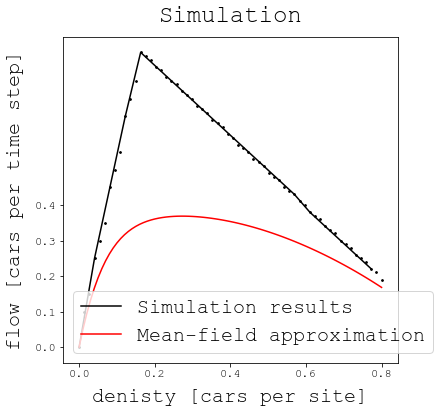

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(t,flow, color ="black", s=3)
plt.plot(t2,flow2, color ="black", label = "Simulation results")
plt.plot(x,flows,color ="red", label = "Mean-field approximation")
plt.yticks([0,.1,.2,.3,.4])
plt.xticks([0,.2,.4,.6,.8])
plt.ylabel('flow [cars per time step]',labelpad=10)
plt.xlabel('denisty [cars per site]',labelpad=10)
plt.title('Simulation',pad=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Courier New"
plt.rcParams["font.size"] = "20"
plt.legend()
plt.show()

In [5]:
a= [1,2,3]
np.sum(a[0:0])

0.0

In [10]:
pdf_next_seq("",10,100)

1

In [12]:
a[3:]

[]